In [169]:
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [170]:
import warnings
import os
from pathlib import Path
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from analysis.risk_hypthesis_tester import RiskHypothesisTester
from utils.load_data import load_local_data

In [171]:
#suppress warning errors
warnings.filterwarnings("ignore")
#load enviroment variables
load_dotenv()

True

In [172]:
# Automatically go to project root (where .git or README.md is)
project_root = Path.cwd()
while not (project_root / "README.md").exists() and project_root != project_root.parent:
    project_root = project_root.parent

os.chdir(project_root)
print("Project root set to:", project_root)


Project root set to: /home/teshager/Documents/10Academy/repositories/projects/insurance-risk-modeling


## 🧱 1. Setup & Imports

In [173]:
# Load the insurance data
processed_data_dir=os.getenv("PROCESSED_DATA")
file_path= os.path.join(processed_data_dir,'cleaned_insurance_data.csv')
df=pd.read_csv(file_path).drop('CustomValueEstimate',axis=1)
df.head()

,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Bank,AccountType,MaritalStatus,...,CalculatedPremiumPerTerm,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,TotalPremium,TotalClaims,Gender_Inferred
0,145249,12827,2015-03-01 00:00:00,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,...,25.0000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,21.929825,0.0,Male
1,145249,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,...,25.0000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,21.929825,0.0,Male
2,145249,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,...,25.0000,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,0.000000,0.0,Male
3,145255,12827,2015-05-01 00:00:00,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,...,584.6468,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,512.848070,0.0,Male
4,145255,12827,2015-07-01 00:00:00,True,,Close Corporation,Mr,First National Bank,Current account,Not specified,...,584.6468,Mobility - Metered Taxis - R2000,Own damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Metered Taxis: Monthly,0.000000,0.0,Male


In [174]:
df.columns.sort_values()

Index(['AccountType', 'AlarmImmobiliser', 'Bank', 'CalculatedPremiumPerTerm',
       'CapitalOutstanding', 'Citizenship', 'Converted', 'CoverCategory',
       'CoverGroup', 'CoverType', 'CrossBorder', 'Cylinders', 'ExcessSelected',
       'Gender_Inferred', 'IsVATRegistered', 'LegalType', 'MainCrestaZone',
       'MaritalStatus', 'Model', 'NewVehicle', 'NumberOfDoors', 'PolicyID',
       'PostalCode', 'Product', 'Province', 'Rebuilt', 'RegistrationYear',
       'Section', 'SubCrestaZone', 'SumInsured', 'TermFrequency', 'Title',
       'TotalClaims', 'TotalPremium', 'TrackingDevice', 'TransactionMonth',
       'UnderwrittenCoverID', 'VehicleIntroDate', 'VehicleType', 'WrittenOff',
       'bodytype', 'cubiccapacity', 'kilowatts', 'make', 'mmcode'],
      dtype='object')

In [175]:
#add a Margin, ClaimFrequency and ClaimSeverity to the df

df['Margin']=df['TotalPremium']-df['TotalClaims']
# Avoid divide-by-zero
df["ClaimSeverity"] = np.where(
    df["SumInsured"] > 0,
    df["TotalClaims"] / df["SumInsured"],
    0
)
df['ClaimFrequency']= (df['TotalClaims']>0).astype(int);

In [176]:
#rename the gender_inferred column

df=df.rename(columns={'Gender_Inferred':"Gender"})
df.columns

Index(['UnderwrittenCoverID', 'PolicyID', 'TransactionMonth',
       'IsVATRegistered', 'Citizenship', 'LegalType', 'Title', 'Bank',
       'AccountType', 'MaritalStatus', 'Province', 'PostalCode',
       'MainCrestaZone', 'SubCrestaZone', 'mmcode', 'VehicleType',
       'RegistrationYear', 'make', 'Model', 'Cylinders', 'cubiccapacity',
       'kilowatts', 'bodytype', 'NumberOfDoors', 'VehicleIntroDate',
       'AlarmImmobiliser', 'TrackingDevice', 'CapitalOutstanding',
       'NewVehicle', 'WrittenOff', 'Rebuilt', 'Converted', 'CrossBorder',
       'SumInsured', 'TermFrequency', 'CalculatedPremiumPerTerm',
       'ExcessSelected', 'CoverCategory', 'CoverType', 'CoverGroup', 'Section',
       'Product', 'TotalPremium', 'TotalClaims', 'Gender', 'Margin',
       'ClaimSeverity', 'ClaimFrequency'],
      dtype='object')

In [177]:

# Initialize the tester
tester = RiskHypothesisTester(df)

### Accept or reject the following Null Hypotheses: 

    H₀:There are no risk differences across provinces 
    H₀:There are no risk differences between zip codes 
    H₀:There are no significant margin (profit) difference between zip codes 
    H₀:There are not significant risk difference between Women and Men

## A. 📍 Geographic Features

### Province

**Check wether to apply Parametric or non-Parametric Method**

In [189]:
tester = RiskHypothesisTester(df)
tester.check_assumptions(group_col="Province", value_col="ClaimFrequency")


📊 Checking Assumptions for 'ClaimFrequency' grouped by 'Province':

🔍 Shapiro-Wilk Normality Test:
  Eastern Cape        : p = 0.0000 → ❌ Not Normal
  Free State          : p = 0.0000 → ❌ Not Normal
  Gauteng             : p = 0.0000 → ❌ Not Normal
  KwaZulu-Natal       : p = 0.0000 → ❌ Not Normal
  Limpopo             : p = 0.0000 → ❌ Not Normal
  Mpumalanga          : p = 0.0000 → ❌ Not Normal
  North West          : p = 0.0000 → ❌ Not Normal
  Northern Cape       : p = 0.0000 → ❌ Not Normal
  Western Cape        : p = 0.0000 → ❌ Not Normal

🧪 Levene’s Test for Equal Variance:
  Levene’s p = 0.0000 → ❌ Variance Not Equal


{'normality_p_values': {'Eastern Cape': 5.391367522248754e-148,
  'Free State': 7.848505147653476e-109,
  'Gauteng': 2.3347257330611732e-219,
  'KwaZulu-Natal': 2.053661869886028e-198,
  'Limpopo': 1.214948385152256e-141,
  'Mpumalanga': 1.4892969665084766e-164,
  'North West': 7.287786883993796e-194,
  'Northern Cape': 3.603050146775611e-102,
  'Western Cape': 9.221628632037399e-199},
 'levene_p_value': 2.690763875185085e-20}

[2025-06-13 16:08:30,087] INFO: Running chi-squared test for Province vs ClaimFrequency...
[2025-06-13 16:08:30,087] INFO: Running chi-squared test for Province vs ClaimFrequency...
[2025-06-13 16:08:30,087] INFO: Running chi-squared test for Province vs ClaimFrequency...
[2025-06-13 16:08:30,087] INFO: Running chi-squared test for Province vs ClaimFrequency...
[2025-06-13 16:08:30,087] INFO: Running chi-squared test for Province vs ClaimFrequency...
[2025-06-13 16:08:30,087] INFO: Running chi-squared test for Province vs ClaimFrequency...
[2025-06-13 16:08:30,087] INFO: Running chi-squared test for Province vs ClaimFrequency...
[2025-06-13 16:08:30,087] INFO: Running chi-squared test for Province vs ClaimFrequency...
[2025-06-13 16:08:30,087] INFO: Running chi-squared test for Province vs ClaimFrequency...
INFO:analysis.risk_hypthesis_tester:Running chi-squared test for Province vs ClaimFrequency...


 Chi-Squared Test: Province vs ClaimFrequency  
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric             ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Chi² Statistic     │ 110.7279               │
│ Degrees of Freedom │ 8                      │
│ P-Value            │ 0.0000                 │
│ Conclusion         │ REJECT null hypothesis │
└────────────────────┴────────────────────────┘

[2025-06-13 16:08:30,284] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:30,284] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:30,284] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:30,284] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:30,284] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:30,284] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:30,284] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:30,284] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:30,284] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
INFO:analysis.risk_hypthesis_tester:Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:30,299] INFO: Visualizing ClaimFrequency by SubCrestaZone (bar plot)...
[2025-06-13 16:08:30,299] INFO: Visualizing Cl

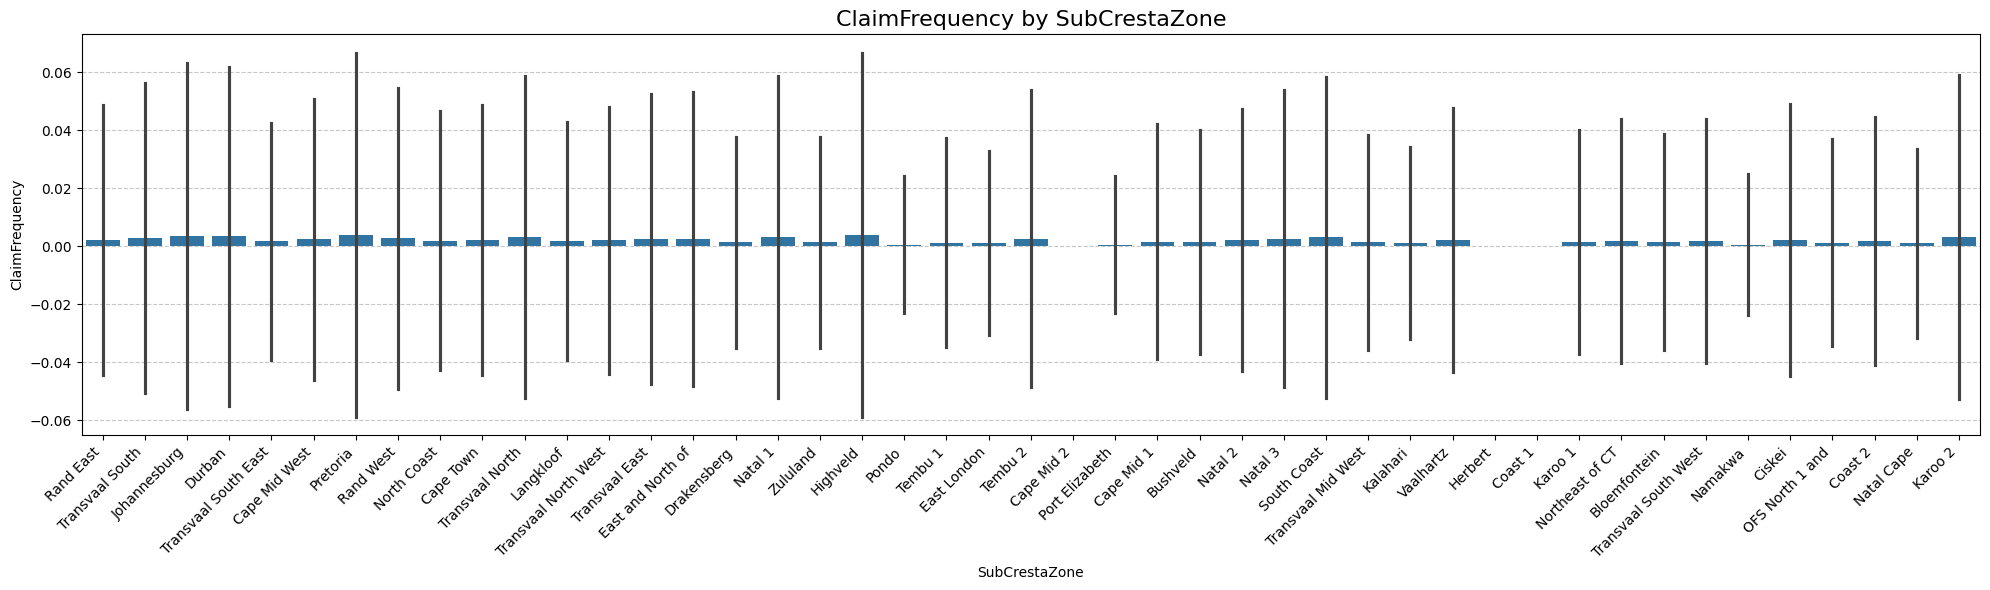

'We reject the null hypothesis that `Province` has no effect on `ClaimFrequency` (p = 0.0000). This indicates no statistically "significant" impact of `Province`'

In [178]:
chi2_result = tester.run_chi2("Province", binary_metric="ClaimFrequency")
tester.export_markdown_report(chi2_result, f"report_chi2_{feature}.md")
tester.visualize_metric(feature, "ClaimFrequency", kind="bar")
tester.interpret_result(chi2_result)

### PostalCode

[2025-06-13 16:08:33,311] INFO: Running chi-squared test for PostalCode vs ClaimFrequency...
[2025-06-13 16:08:33,311] INFO: Running chi-squared test for PostalCode vs ClaimFrequency...
[2025-06-13 16:08:33,311] INFO: Running chi-squared test for PostalCode vs ClaimFrequency...
[2025-06-13 16:08:33,311] INFO: Running chi-squared test for PostalCode vs ClaimFrequency...
[2025-06-13 16:08:33,311] INFO: Running chi-squared test for PostalCode vs ClaimFrequency...
[2025-06-13 16:08:33,311] INFO: Running chi-squared test for PostalCode vs ClaimFrequency...
[2025-06-13 16:08:33,311] INFO: Running chi-squared test for PostalCode vs ClaimFrequency...
[2025-06-13 16:08:33,311] INFO: Running chi-squared test for PostalCode vs ClaimFrequency...
[2025-06-13 16:08:33,311] INFO: Running chi-squared test for PostalCode vs ClaimFrequency...
INFO:analysis.risk_hypthesis_tester:Running chi-squared test for PostalCode vs ClaimFrequency...


Chi-Squared Test: PostalCode vs ClaimFrequency 
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric             ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Chi² Statistic     │ 1451.6755              │
│ Degrees of Freedom │ 887                    │
│ P-Value            │ 0.0000                 │
│ Conclusion         │ REJECT null hypothesis │
└────────────────────┴────────────────────────┘

[2025-06-13 16:08:33,461] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:33,461] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:33,461] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:33,461] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:33,461] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:33,461] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:33,461] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:33,461] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:33,461] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
INFO:analysis.risk_hypthesis_tester:Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:33,475] INFO: Visualizing ClaimFrequency by SubCrestaZone (bar plot)...
[2025-06-13 16:08:33,475] INFO: Visualizing Cl

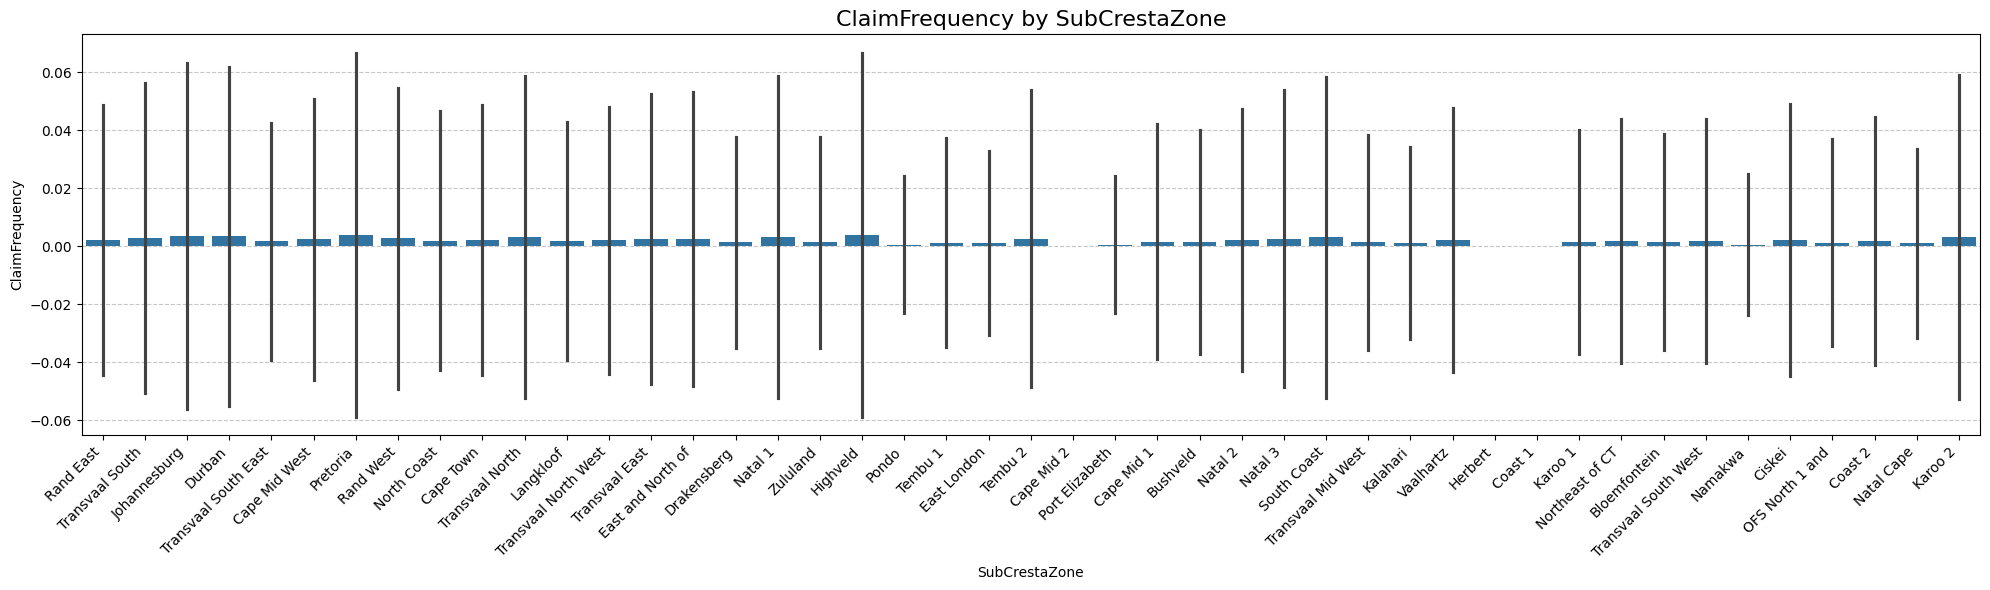

'We reject the null hypothesis that `PostalCode` has no effect on `ClaimFrequency` (p = 0.0000). This indicates no statistically "significant" impact of `PostalCode`'

In [179]:
chi2_result = tester.run_chi2("PostalCode", binary_metric="ClaimFrequency")
tester.export_markdown_report(chi2_result, f"report_chi2_{feature}.md")
tester.visualize_metric(feature, "ClaimFrequency", kind="bar")
tester.interpret_result(chi2_result)

###  MainCrestaZone & SubCrestaZone

[2025-06-13 16:08:36,477] INFO: Running chi-squared test for MainCrestaZone vs ClaimFrequency...
[2025-06-13 16:08:36,477] INFO: Running chi-squared test for MainCrestaZone vs ClaimFrequency...
[2025-06-13 16:08:36,477] INFO: Running chi-squared test for MainCrestaZone vs ClaimFrequency...
[2025-06-13 16:08:36,477] INFO: Running chi-squared test for MainCrestaZone vs ClaimFrequency...
[2025-06-13 16:08:36,477] INFO: Running chi-squared test for MainCrestaZone vs ClaimFrequency...
[2025-06-13 16:08:36,477] INFO: Running chi-squared test for MainCrestaZone vs ClaimFrequency...
[2025-06-13 16:08:36,477] INFO: Running chi-squared test for MainCrestaZone vs ClaimFrequency...
[2025-06-13 16:08:36,477] INFO: Running chi-squared test for MainCrestaZone vs ClaimFrequency...
[2025-06-13 16:08:36,477] INFO: Running chi-squared test for MainCrestaZone vs ClaimFrequency...
INFO:analysis.risk_hypthesis_tester:Running chi-squared test for MainCrestaZone vs ClaimFrequency...


      Chi-Squared Test: MainCrestaZone vs      
                ClaimFrequency                 
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric             ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Chi² Statistic     │ 182.0177               │
│ Degrees of Freedom │ 15                     │
│ P-Value            │ 0.0000                 │
│ Conclusion         │ REJECT null hypothesis │
└────────────────────┴────────────────────────┘

[2025-06-13 16:08:36,731] INFO: Markdown report saved to report_chi2_MainCrestaZone.md
[2025-06-13 16:08:36,731] INFO: Markdown report saved to report_chi2_MainCrestaZone.md
[2025-06-13 16:08:36,731] INFO: Markdown report saved to report_chi2_MainCrestaZone.md
[2025-06-13 16:08:36,731] INFO: Markdown report saved to report_chi2_MainCrestaZone.md
[2025-06-13 16:08:36,731] INFO: Markdown report saved to report_chi2_MainCrestaZone.md
[2025-06-13 16:08:36,731] INFO: Markdown report saved to report_chi2_MainCrestaZone.md
[2025-06-13 16:08:36,731] INFO: Markdown report saved to report_chi2_MainCrestaZone.md
[2025-06-13 16:08:36,731] INFO: Markdown report saved to report_chi2_MainCrestaZone.md
[2025-06-13 16:08:36,731] INFO: Markdown report saved to report_chi2_MainCrestaZone.md
INFO:analysis.risk_hypthesis_tester:Markdown report saved to report_chi2_MainCrestaZone.md
[2025-06-13 16:08:36,747] INFO: Visualizing ClaimFrequency by MainCrestaZone (bar plot)...
[2025-06-13 16:08:36,747] INFO: Vis

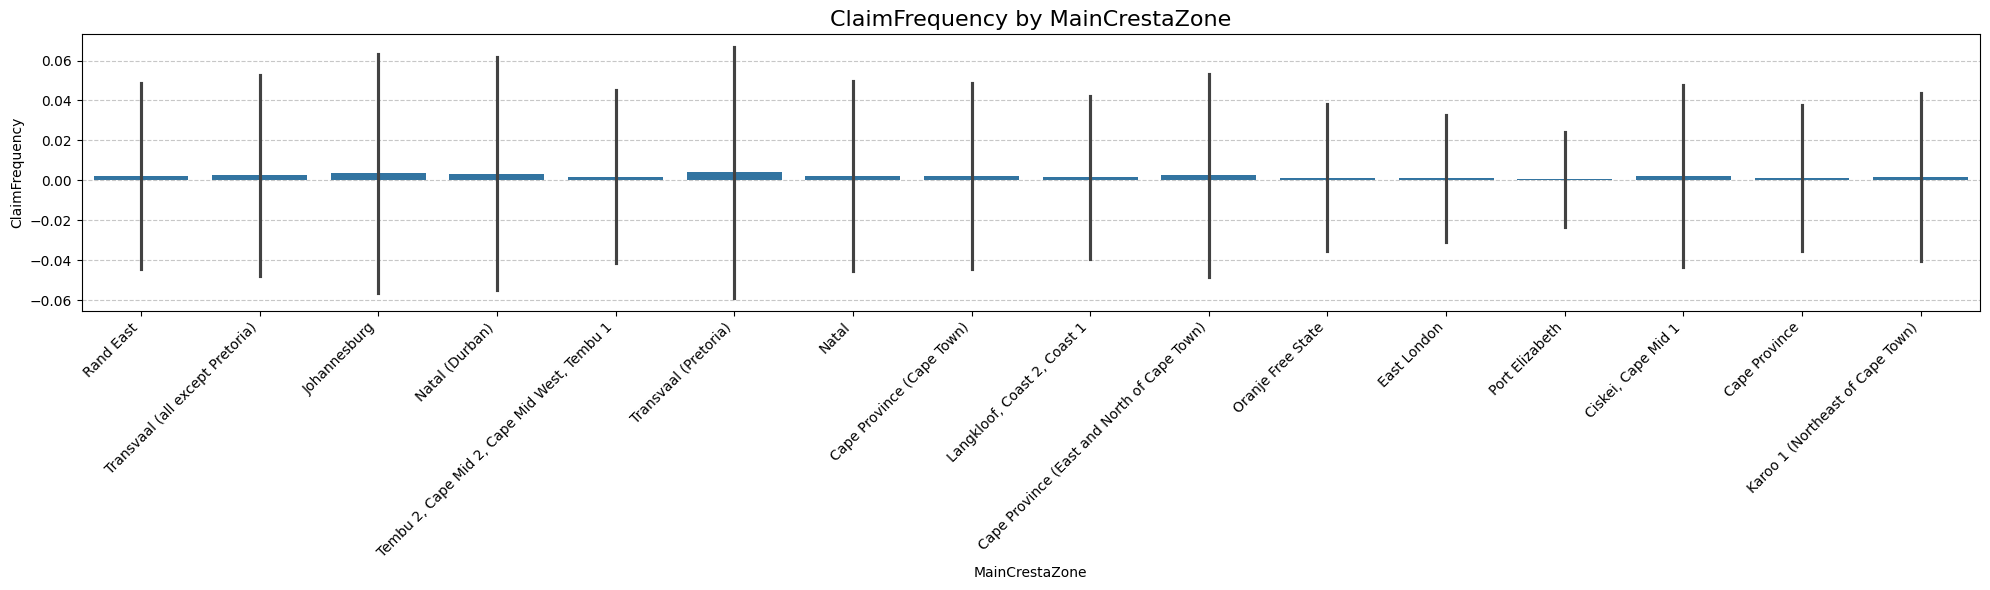

[2025-06-13 16:08:39,395] INFO: Running chi-squared test for SubCrestaZone vs ClaimFrequency...
[2025-06-13 16:08:39,395] INFO: Running chi-squared test for SubCrestaZone vs ClaimFrequency...
[2025-06-13 16:08:39,395] INFO: Running chi-squared test for SubCrestaZone vs ClaimFrequency...
[2025-06-13 16:08:39,395] INFO: Running chi-squared test for SubCrestaZone vs ClaimFrequency...
[2025-06-13 16:08:39,395] INFO: Running chi-squared test for SubCrestaZone vs ClaimFrequency...
[2025-06-13 16:08:39,395] INFO: Running chi-squared test for SubCrestaZone vs ClaimFrequency...
[2025-06-13 16:08:39,395] INFO: Running chi-squared test for SubCrestaZone vs ClaimFrequency...
[2025-06-13 16:08:39,395] INFO: Running chi-squared test for SubCrestaZone vs ClaimFrequency...
[2025-06-13 16:08:39,395] INFO: Running chi-squared test for SubCrestaZone vs ClaimFrequency...
INFO:analysis.risk_hypthesis_tester:Running chi-squared test for SubCrestaZone vs ClaimFrequency...


      Chi-Squared Test: SubCrestaZone vs       
                ClaimFrequency                 
┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric             ┃ Value                  ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Chi² Statistic     │ 226.9811               │
│ Degrees of Freedom │ 44                     │
│ P-Value            │ 0.0000                 │
│ Conclusion         │ REJECT null hypothesis │
└────────────────────┴────────────────────────┘

[2025-06-13 16:08:39,587] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:39,587] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:39,587] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:39,587] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:39,587] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:39,587] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:39,587] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:39,587] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:39,587] INFO: Markdown report saved to report_chi2_SubCrestaZone.md
INFO:analysis.risk_hypthesis_tester:Markdown report saved to report_chi2_SubCrestaZone.md
[2025-06-13 16:08:39,598] INFO: Visualizing ClaimFrequency by SubCrestaZone (bar plot)...
[2025-06-13 16:08:39,598] INFO: Visualizing Cl

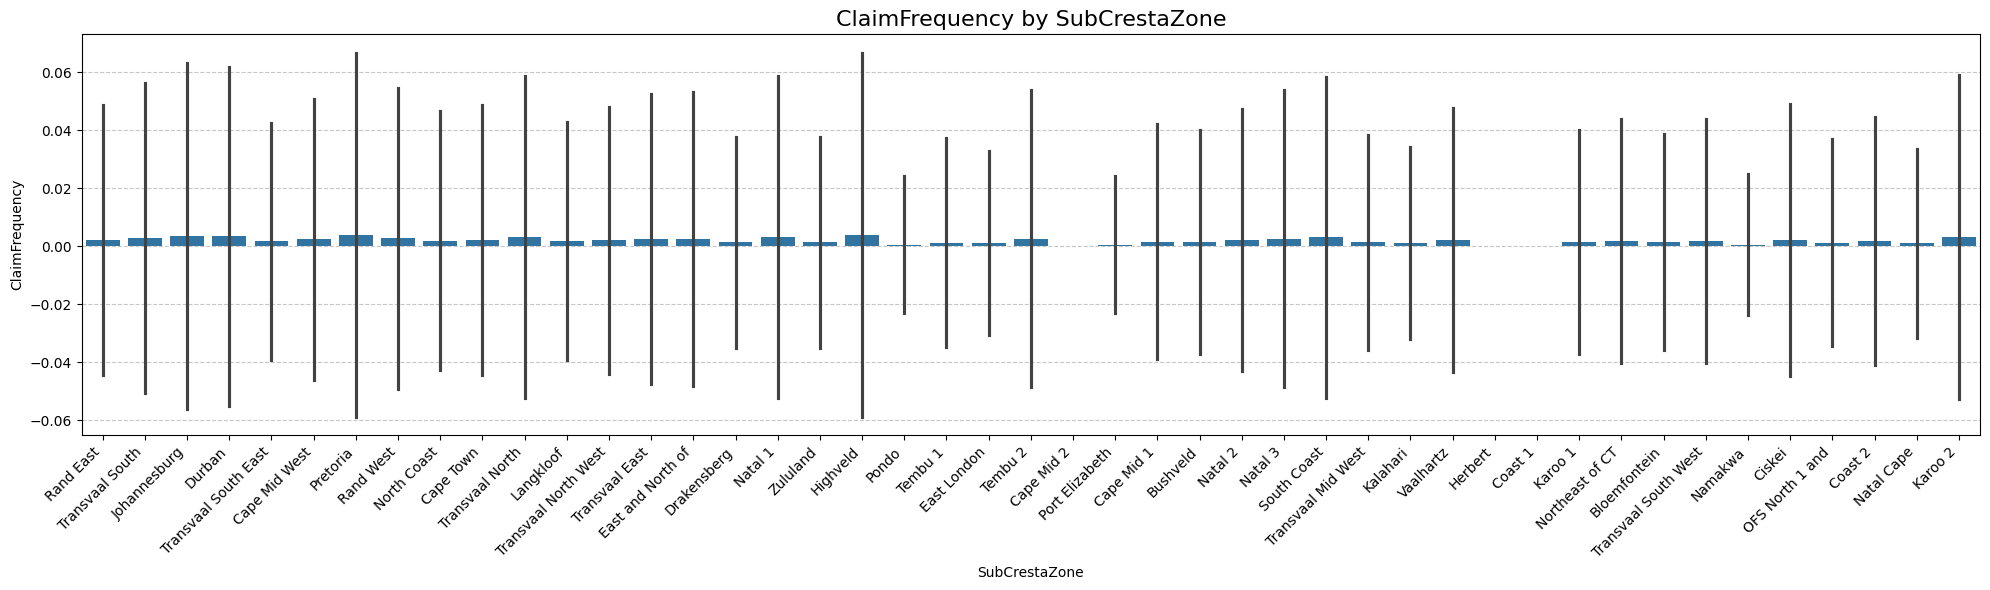

In [180]:
geo_features = ['MainCrestaZone', 'SubCrestaZone']

for feature in geo_features:
    try:
        chi2_result = tester.run_chi2(feature, binary_metric="ClaimFrequency")
        tester.export_markdown_report(chi2_result, f"report_chi2_{feature}.md")
        tester.visualize_metric(feature, "ClaimFrequency", kind="bar")
        tester.interpret_result(chi2_result)
    except Exception as e:
        print(f"Chi-squared test failed for {feature}: {e}")


## B. 👨‍👩‍👧 Demographic Features

### Gender

In [181]:
# Define columns
group_col = 'Gender'
metric_col = 'TotalClaims'


In [182]:
df['Gender'].value_counts()

Gender
Male      933812
Female     65732
Name: count, dtype: int64

In [183]:
# Run the test
# result = tester.two_sample_ttest(group_col=group_col, metric_col=metric_col, equal_var=False)
result= tester.run_ttest(feature=group_col,metric=metric_col)

[2025-06-13 16:08:42,679] INFO: Running t-test for TotalClaims by Gender...
[2025-06-13 16:08:42,679] INFO: Running t-test for TotalClaims by Gender...
[2025-06-13 16:08:42,679] INFO: Running t-test for TotalClaims by Gender...
[2025-06-13 16:08:42,679] INFO: Running t-test for TotalClaims by Gender...
[2025-06-13 16:08:42,679] INFO: Running t-test for TotalClaims by Gender...
[2025-06-13 16:08:42,679] INFO: Running t-test for TotalClaims by Gender...
[2025-06-13 16:08:42,679] INFO: Running t-test for TotalClaims by Gender...
[2025-06-13 16:08:42,679] INFO: Running t-test for TotalClaims by Gender...
[2025-06-13 16:08:42,679] INFO: Running t-test for TotalClaims by Gender...
INFO:analysis.risk_hypthesis_tester:Running t-test for TotalClaims by Gender...


  T-Test Result: Gender vs TotalClaims  
┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Metric      ┃ Value                  ┃
┡━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Group A     │ Male                   │
│ Group B     │ Female                 │
│ T-Statistic │ 2.2504                 │
│ P-Value     │ 0.0244                 │
│ Conclusion  │ REJECT null hypothesis │
└─────────────┴────────────────────────┘

In [184]:
# View result
print(result)

{'feature': 'Gender', 'metric': 'TotalClaims', 'group_a': 'Male', 'group_b': 'Female', 't_stat': 2.250445015518036, 'p_value': 0.024423519322613906, 'conclusion': 'REJECT'}


[2025-06-13 16:08:43,982] INFO: Visualizing ClaimFrequency by Gender (bar plot)...
[2025-06-13 16:08:43,982] INFO: Visualizing ClaimFrequency by Gender (bar plot)...
[2025-06-13 16:08:43,982] INFO: Visualizing ClaimFrequency by Gender (bar plot)...
[2025-06-13 16:08:43,982] INFO: Visualizing ClaimFrequency by Gender (bar plot)...
[2025-06-13 16:08:43,982] INFO: Visualizing ClaimFrequency by Gender (bar plot)...
[2025-06-13 16:08:43,982] INFO: Visualizing ClaimFrequency by Gender (bar plot)...
[2025-06-13 16:08:43,982] INFO: Visualizing ClaimFrequency by Gender (bar plot)...
[2025-06-13 16:08:43,982] INFO: Visualizing ClaimFrequency by Gender (bar plot)...
[2025-06-13 16:08:43,982] INFO: Visualizing ClaimFrequency by Gender (bar plot)...
INFO:analysis.risk_hypthesis_tester:Visualizing ClaimFrequency by Gender (bar plot)...


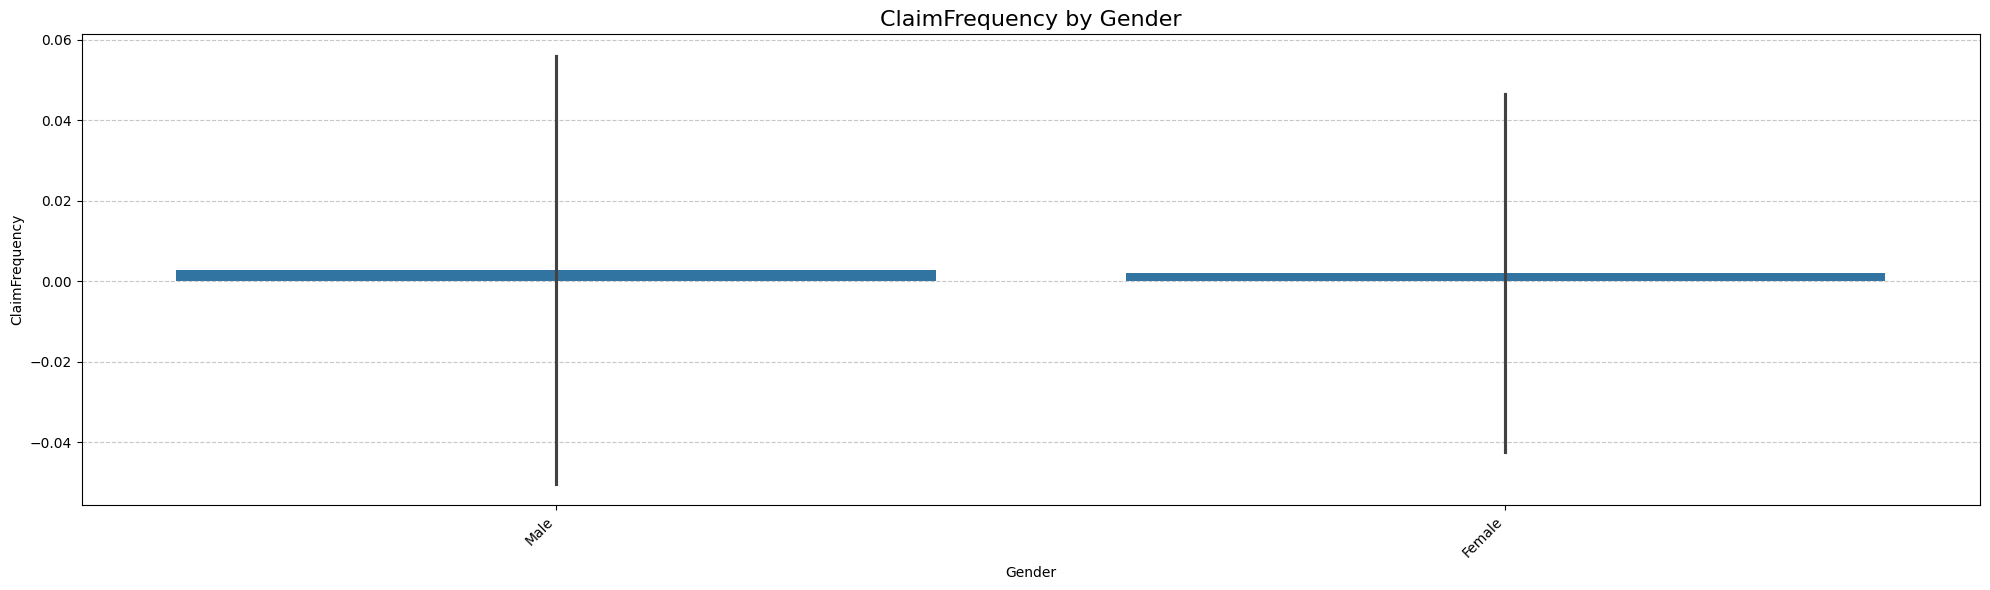

In [185]:
tester.visualize_metric('Gender', "ClaimFrequency", kind="bar")

In [186]:
tester.interpret_result(result)

'We reject the null hypothesis that `Gender` has no effect on `TotalClaims` (p = 0.0244). This indicates no statistically "significant" impact of `Gender`'

<div style="border-radius:10px; border:orange solid; padding: 15px; font-size:100%; text-align:left; font-color:#325939;background-color:#2c2c2c">
<h3 align="left"><font color='orange'>💡 Conclusion:</font></h3>

* 'We reject the null hypothesis that `Gender` has no effect on `TotalClaims` (p = 0.0244). This suggests that `Gender` is a significant factor affecting `TotalClaims`. Consider using it in segmentation strategy or premium pricing.'
</div>

In [187]:
tester.export_markdown_report(result,'reports/hypothesis_report.md')

[2025-06-13 16:08:46,435] INFO: Markdown report saved to reports/hypothesis_report.md
[2025-06-13 16:08:46,435] INFO: Markdown report saved to reports/hypothesis_report.md
[2025-06-13 16:08:46,435] INFO: Markdown report saved to reports/hypothesis_report.md
[2025-06-13 16:08:46,435] INFO: Markdown report saved to reports/hypothesis_report.md
[2025-06-13 16:08:46,435] INFO: Markdown report saved to reports/hypothesis_report.md
[2025-06-13 16:08:46,435] INFO: Markdown report saved to reports/hypothesis_report.md
[2025-06-13 16:08:46,435] INFO: Markdown report saved to reports/hypothesis_report.md
[2025-06-13 16:08:46,435] INFO: Markdown report saved to reports/hypothesis_report.md
[2025-06-13 16:08:46,435] INFO: Markdown report saved to reports/hypothesis_report.md
INFO:analysis.risk_hypthesis_tester:Markdown report saved to reports/hypothesis_report.md
